In [2]:
import re
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import linear_kernel
from collections import Counter
from wordcloud import WordCloud

## Preprocessing Laptop Dataset

In [3]:
df_laptop=pd.read_csv('laptops.csv')

In [4]:
df_laptop.columns

Index(['link', 'Brand', 'Model', 'Company', 'picture', 'Price in India',
       '1 stars', '2 stars', '4 stars', '3 stars', '5 stars', 'total_ratings',
       'RAM', 'Size', 'SSD', 'Colours', 'Operating system', 'Hard disk',
       'Model Number', 'Processor', 'Graphics Processor', 'Dedicated Graphics',
       'Finger Print Sensor', 'Resolution', 'Wi-Fi standards supported',
       'Weight (kg)', 'Dimensions (mm)', 'Bluetooth version',
       'Number of USB Ports', 'Series', 'Internal Mic', 'Touch Screen',
       'Base Clock Speed', 'Graphics Processor.1', 'Product Name', 'Touchpad',
       'Battery Cell', 'Pointer Device', 'USB Ports', 'Cache', 'Mic In',
       'Speakers', 'Multi Card Slot', 'RJ45 (LAN)', 'Dedicated Graphics.1',
       'HDMI Port', 'Ethernet', 'Battery Life (up to hours)',
       'Dedicated Graphic Memory Type', 'Expandable RAM up to (GB)',
       'other_info'],
      dtype='object')

In [5]:
#Finding the null value percentage
df_laptop.isnull().mean()

link                             0.000000
Brand                            0.000000
Model                            0.000000
Company                          0.000000
picture                          0.000000
Price in India                   0.364903
1 stars                          0.000000
2 stars                          0.000000
4 stars                          0.000000
3 stars                          0.000000
5 stars                          0.000000
total_ratings                    0.596498
RAM                              0.014127
Size                             0.020294
SSD                              0.021488
Colours                          0.025269
Operating system                 0.028452
Hard disk                        0.041385
Model Number                     0.044369
Processor                        0.044966
Graphics Processor               0.345404
Dedicated Graphics               0.589136
Finger Print Sensor              0.155193
Resolution                       0

In [6]:
#Dropping the Columns which have higher null value, also the columns which doesn't have impact on the model performance
Columns=['link', 'Company',
       '1 stars', '2 stars', '4 stars', '3 stars', '5 stars', 'total_ratings',
       'Size',
       'Model Number', 'Dedicated Graphics',
       'Finger Print Sensor', 'Resolution', 'Wi-Fi standards supported',
       'Weight (kg)', 'Dimensions (mm)', 'Bluetooth version',
       'Number of USB Ports', 'Series', 'Internal Mic',
       'Base Clock Speed', 'Graphics Processor.1', 'Product Name', 'Touchpad',
       'Battery Cell', 'Pointer Device', 'USB Ports', 'Cache', 'Mic In',
       'Speakers', 'Multi Card Slot', 'RJ45 (LAN)', 'Dedicated Graphics.1',
       'HDMI Port', 'Ethernet', 
       'Dedicated Graphic Memory Type', 'Expandable RAM up to (GB)',
       'other_info']

In [7]:
df_laptop.drop(columns=Columns, inplace=True)

In [8]:
df_laptop.isnull().mean()

Brand                         0.000000
Model                         0.000000
picture                       0.000000
Price in India                0.364903
RAM                           0.014127
SSD                           0.021488
Colours                       0.025269
Operating system              0.028452
Hard disk                     0.041385
Processor                     0.044966
Graphics Processor            0.345404
Touch Screen                  0.343016
Battery Life (up to hours)    0.639077
dtype: float64

### Handling Price Column

In [9]:
df_laptop['Price in India'].shape

(5026,)

In [10]:
# Removing symbols,space and comma 
df_laptop['Price in India'] = df_laptop['Price in India'].str.replace('₹', '').str.replace(' ', '').str.replace(',', '').astype(float)


In [11]:
df_laptop['Price in India'].isnull().sum()

1834

In [12]:
# Handling missign values using mean 
df_laptop['Price in India'].fillna(df_laptop['Price in India'].mean(), inplace=True)

In [13]:
# Changing name of the price column 
df_laptop.rename(columns={'Price in India': 'Price'}, inplace=True)

### RAM

In [14]:
df_laptop['RAM'].unique()

array(['4GB', '16GB', '6GB', '8GB', '12GB', '2GB', nan, '32GB', '64GB',
       '1GB', '24GB', '3GB', '10GB GDDR6 RAM', '16GB GDDR6'], dtype=object)

In [15]:
# Deleting these two records beacuse it does not have correct values
values_to_delete = ['16 GDDR6', '10 GDDR6 RAM']
df_laptop = df_laptop[~df_laptop['RAM'].isin(values_to_delete)]

In [16]:
# Dropping the resords which are null 
df_laptop.dropna(subset=['RAM'], inplace=True)

In [17]:
df_laptop.isnull().mean()

Brand                         0.000000
Model                         0.000000
picture                       0.000000
Price                         0.000000
RAM                           0.000000
SSD                           0.010696
Colours                       0.019374
Operating system              0.027043
Hard disk                     0.031282
Processor                     0.039556
Graphics Processor            0.341271
Touch Screen                  0.339051
Battery Life (up to hours)    0.639960
dtype: float64

### SSD Column

In [18]:
df_laptop['SSD'].unique()

array([nan, 'No', '512GB', '24GB', '256GB', '128GB', '1TB', '64GB',
       '32GB', '480GB', '2TB', '240GB', '16GB', '8GB', '360GB', '180GB'],
      dtype=object)

In [19]:
# Dropping the missing value records 
df_laptop.dropna(subset=['SSD'],inplace=True)

## Operating system

In [20]:
df_laptop['Operating system'].unique()

array(['Windows 10 Home', 'Windows 10', 'DOS', 'Linux', 'Windows 8',
       'Windows 8.1', 'Windows 10 Professional', 'Windows 8 Professional',
       'Ubuntu', 'Windows 8.1 Professional', 'macOS', nan, 'Chrome OS',
       'Windows 7 Professional', 'Endless', 'Windows 7', 'Android',
       'Windows'], dtype=object)

In [21]:
# Cleaning values in the column
df_laptop['Operating system']=df_laptop['Operating system'].str.replace('Home','').str.replace('Professional','').str.replace(' ','')

In [22]:
# Handling missing values uisng mode
df_laptop['Operating system']=df_laptop['Operating system'].fillna(df_laptop['Operating system'].mode().iloc[0])

## Funtion to Fill the missing values of the categorical columns using Mode Operation 

In [23]:
def fillna_mode(df, columns):
    for column in columns:
        df[column] = df[column].fillna(df[column].mode().iloc[0])
    return df



### 'Colours', 'Hard disk', 'Processor', 'Graphics Processor', 'Touch Screen', 'Battery Life (up to hours)' are handled by calling the mode function

In [24]:
# List of columns to fill missing values with mode
columns_to_fill = ['Colours', 'Hard disk', 'Processor', 'Graphics Processor', 'Touch Screen', 'Battery Life (up to hours)']

df_laptop = fillna_mode(df_laptop, columns_to_fill)

In [25]:
# converting from float to Int
df_laptop['Battery Life (up to hours)']=df_laptop['Battery Life (up to hours)'].astype(int)

In [26]:
df_laptop.isnull().sum()

Brand                         0
Model                         0
picture                       0
Price                         0
RAM                           0
SSD                           0
Colours                       0
Operating system              0
Hard disk                     0
Processor                     0
Graphics Processor            0
Touch Screen                  0
Battery Life (up to hours)    0
dtype: int64

## No Missing Values found!


## Handling Duplicates

In [27]:
df_laptop.duplicated().sum()

1039

In [28]:
df_laptop.drop_duplicates(inplace=True)

In [29]:
df_laptop.duplicated().sum()

0

## Duplicates Removed!

## Creating new column for the data to be considered as laptop, because it will be help to identify the records of laptop when we combine them

In [30]:
df_laptop['Gadget']='laptop'

In [31]:
df_laptop.head()

,Brand,Model,picture,Price,RAM,SSD,Colours,Operating system,Hard disk,Processor,Graphics Processor,Touch Screen,Battery Life (up to hours),Gadget
1,HP,Pavilion 15-ab205tx,https://i.gadgets360cdn.com/products/laptops/l...,49790.0,4GB,No,Natural Silver,Windows10,1TB,Intel Core i5 5th Gen 5200U,AMD Radeon R5 M335,No,4,laptop
2,HP,Pavilion 15-AU626TX,https://i.gadgets360cdn.com/products/laptops/l...,69980.0,16GB,No,Silver,Windows10,2TB,Intel Core i5 7th Gen 7200U,Nvidia GeForce 940MX,No,5,laptop
3,Asus,R558UQ-DM539D,https://i.gadgets360cdn.com/products/laptops/l...,35490.0,4GB,No,Glossy Dark Brown,DOS,1TB,Intel Core i5 7th Gen 7200U,Nvidia GeForce 940MX,No,4,laptop
4,HP,240 G4,https://i.gadgets360cdn.com/products/laptops/l...,27500.0,4GB,No,Black,DOS,500GB,Intel Core i3 5th Gen 5010U,AMD Radeon R5 M330,No,3,laptop
6,Acer,Aspire E E1-572G,https://i.gadgets360cdn.com/products/laptops/l...,59500.0,4GB,No,Black,Linux,1TB,Intel Core i7 4th Gen 4500U,AMD Radeon 8750M,No,4,laptop


## Changing to appropriate names suitable for all the Datasets

In [32]:
# Creating a dictionary to map old column names to the new column name
column_mapping = {
    'Brand': 'Brand name',
    'Model': 'Model number',
    'picture': 'picture url',
    'Battery Life (up to hours)': 'Battery Life',
    'Colours': 'colour',
}
df_laptop = df_laptop.rename(columns=column_mapping)

# Check the updated column names
print(df_laptop.columns)


Index(['Brand name', 'Model number', 'picture url', 'Price', 'RAM', 'SSD',
       'colour', 'Operating system', 'Hard disk', 'Processor',
       'Graphics Processor', 'Touch Screen', 'Battery Life', 'Gadget'],
      dtype='object')


# Done with the Preprocessing of Laptop Dataset!!!

## Preprocessing Mobile Dataset

In [33]:
df_mobile=pd.read_csv('mobiles.csv')

In [34]:
df_mobile.columns

Index(['url', 'Brand', 'Product Name', 'Model', 'Picture URL', '1 Stars',
       '2 Stars', '3 Stars', '4 Stars', '5 Stars', 'Total Ratings',
       'Price in India', 'Battery capacity (mAh)', 'Processor',
       'Operating system', 'Rear camera', 'Front camera', 'Internal storage',
       'Resolution', 'RAM', 'Form factor', 'Screen size (inches)', 'Wi-Fi',
       'Bluetooth', 'Touchscreen', 'Expandable storage', 'Launched',
       'Accelerometer', 'GPS', 'Number of SIMs', 'Sim 1 4G/ LTE',
       'Sim 2 4G/ LTE', 'Sim 1 3G', 'Sim 2 3G', 'Sim 2 GSM/CDMA',
       'Sim 1 GSM/CDMA', 'Proximity sensor', 'Ambient light sensor',
       'Rear flash', 'Compass/ Magnetometer', 'Gyroscope',
       'Expandable storage type', 'Headphones', 'Removable battery',
       'Dimensions (mm)', 'Colours', 'Expandable storage up to (GB)', 'FM',
       'NFC', 'USB OTG', 'Wi-Fi Direct', 'Processor make', 'Infrared',
       'other_info'],
      dtype='object')

In [35]:
df_mobile.isnull().mean()

url                              0.000000
Brand                            0.000000
Product Name                     0.350085
Model                            0.000000
Picture URL                      0.000000
1 Stars                          0.000000
2 Stars                          0.000000
3 Stars                          0.000000
4 Stars                          0.000000
5 Stars                          0.000000
Total Ratings                    0.312137
Price in India                   0.350085
Battery capacity (mAh)           0.030427
Processor                        0.032137
Operating system                 0.035214
Rear camera                      0.000912
Front camera                     0.004217
Internal storage                 0.054929
Resolution                       0.062108
RAM                              0.073504
Form factor                      0.073618
Screen size (inches)             0.009345
Wi-Fi                            0.010142
Bluetooth                        0

In [36]:
#Dropping the Columns which have higher null value, also the columns which doesn't have impact on the model performance
Columns=['url', 'Product Name',
       '1 Stars', '2 Stars', '4 Stars', '3 Stars', '5 Stars', 'Total Ratings',
       'Form factor',
       'Screen size (inches)', 'Wi-Fi','Processor',
       'Bluetooth', 'Resolution', 'Expandable storage',
       'Launched', 'Accelerometer', 'Number of SIMs',
       'Sim 1 4G/ LTE','Operating system','GPS',
       'Sim 2 4G/ LTE','Sim 1 3G', 'Sim 2 3G', 'Sim 2 GSM/CDMA',
       'Sim 1 GSM/CDMA', 'Proximity sensor', 'Ambient light sensor',
       'Rear flash', 'Compass/ Magnetometer', 'Gyroscope',
       'Expandable storage type', 'Headphones', 'Removable battery',
       'Dimensions (mm)', 'Expandable storage up to (GB)', 'FM',
       'NFC', 'USB OTG', 'Wi-Fi Direct', 'Processor make', 'Infrared',
       'other_info']

In [37]:
df_mobile.drop(columns=Columns, inplace=True)

In [38]:
df_mobile.isnull().mean()

Brand                     0.000000
Model                     0.000000
Picture URL               0.000000
Price in India            0.350085
Battery capacity (mAh)    0.030427
Rear camera               0.000912
Front camera              0.004217
Internal storage          0.054929
RAM                       0.073504
Touchscreen               0.015157
Colours                   0.211054
dtype: float64

### Handling Price Column

In [39]:
df_mobile['Price in India'].isnull().mean()

0.3500854700854701

In [40]:
# Removing symbols,space and comma 
df_mobile['Price in India'] = df_mobile['Price in India'].str.replace('₹', '').str.replace(' ', '').str.replace(',', '').astype(float)


In [41]:
df_mobile['Price in India'].isnull().sum()

3072

In [42]:
# Deleting the records which contains null values 
df_mobile.dropna(subset=['Price in India'], inplace=True)

In [43]:
# Changing name of the price column 
df_mobile.rename(columns={'Price in India': 'Price'}, inplace=True)

## Dealing with Rear Camera column 

In [44]:
df_mobile['Rear camera'].head(100)

0             12-megapixel (f/1.8) + 5-megapixel (f/2.4)
1             12-megapixel (f/1.8) + 5-megapixel (f/2.4)
2             12-megapixel (f/1.8) + 5-megapixel (f/2.4)
3      12-megapixel (f/2.2, 1.25-micron) + 5-megapixe...
4      12-megapixel (f/2.2, 1.25-micron) + 5-megapixe...
                             ...                        
96                      16-megapixel (f/2.0, 1.0-micron)
97                      16-megapixel (f/2.0, 1.0-micron)
98                    13-megapixel (f/2.0) + 5-megapixel
99                      16-megapixel (f/2.0, 1.0-micron)
100    12-megapixel (f/1.8) + 64-megapixel (f/2.0) + ...
Name: Rear camera, Length: 100, dtype: object

In [45]:
## As we can see the data is in the Rear column present numeric as well string in the elements, 
## but we are more conserned about the numeric stuff, so i have extarcted the values from the existing string i.e Feature engineering
df_mobile['Rear camera']=df_mobile['Rear camera'].str.extract(r'^(\d+)')


For Rear Camera still we have missing values that we will handle using mode operation by calling our exesting function.

## Front Column 

In [46]:
df_mobile['Front camera'].head(100)

0                  25-megapixel (f/2.0)
1                  25-megapixel (f/2.0)
2                  25-megapixel (f/2.0)
3      20-megapixel (f/2.2, 1.0-micron)
4      20-megapixel (f/2.2, 1.0-micron)
                     ...               
96                 24-megapixel (f/2.0)
97                 24-megapixel (f/2.0)
98                          8-megapixel
99                 24-megapixel (f/2.0)
100                10-megapixel (f/2.2)
Name: Front camera, Length: 100, dtype: object

In [47]:
## Similar to Rear Column we are doing the feature engineering
df_mobile['Front camera']=df_mobile['Front camera'].str.extract(r'^(\d+)')

For Front camera also we have missing values that we will handle using mode operation by calling our exesting function.

## Internal storage

In [48]:
df_mobile['Internal storage'].unique()

array(['64GB', '32GB', '16GB', '128GB', '256GB', '512GB', '8GB', '4GB',
       '120MB', '3GB', nan, '64MB', '1GB', '512MB', '20MB', '128MB',
       '2GB', '160MB', '10MB', '75MB', '164MB', '256MB', '2.9GB', '150MB',
       '32MB', '1.25GB', '30MB', '140MB', '104MB', '170MB', '161MB',
       '202MB', '162MB', '158MB', '350MB', '40MB', '4MB'], dtype=object)

In [49]:
df_mobile['Internal storage'].isnull().sum()

34

In [50]:
# Dropping the records 
df_mobile.dropna(subset='Internal storage', inplace=True)

## RAM

In [51]:
df_mobile['RAM'].unique()

array(['6GB', '4GB', '3GB', '2GB', nan, '8GB', '12GB', '1.5GB', '1GB',
       '768MB', '512MB', '256MB', '64MB', '20MB', '384MB', '32MB',
       '128MB', '2MB', '290MB', '150MB', '4MB'], dtype=object)

In [52]:
## Dropping the records 
df_mobile.dropna(subset='RAM', inplace=True)

## Battery capacity (mAh)

In [53]:
df_mobile['Battery capacity (mAh)'].mode()

0    3000.0
Name: Battery capacity (mAh), dtype: float64

In [54]:
## Fill the missing values with mode
df_mobile['Battery capacity (mAh)'].fillna(df_mobile['Battery capacity (mAh)'].mode()[0], inplace=True)

In [55]:
# converting from float to Int
df_mobile['Battery capacity (mAh)']=df_mobile['Battery capacity (mAh)'].astype(int)

## Handling these Columns "Rear camera,Touchscreen,Colours " from mode operation by calling the function

In [56]:
# List of columns to fill missing values with mode
columns_to_fill = ['Rear camera', 'Front camera', 'Touchscreen', 'Colours']

df_mobile = fillna_mode(df_mobile, columns_to_fill)

In [57]:
df_mobile.isnull().sum()

Brand                     0
Model                     0
Picture URL               0
Price                     0
Battery capacity (mAh)    0
Rear camera               0
Front camera              0
Internal storage          0
RAM                       0
Touchscreen               0
Colours                   0
dtype: int64

## All the missing values has been removed!

## Handling Duplicates

In [58]:
df_mobile.duplicated().sum()

869

In [59]:
df_mobile.drop_duplicates(inplace=True)

In [60]:
df_mobile.duplicated().sum()

0

## Duplicates removed!

## Creating new column for the data to be considered as Mobile, because it will be help to identify the records of Mobile when we combine them

In [61]:
df_mobile['Gadget']='mobile'

In [62]:
df_mobile.head()

,Brand,Model,Picture URL,Price,Battery capacity (mAh),Rear camera,Front camera,Internal storage,RAM,Touchscreen,Colours,Gadget
0,Vivo,V11 Pro,https://i.gadgets360cdn.com/products/large/153...,28990.0,3400,12,25,64GB,6GB,Yes,"Dazzling Gold, Starry Black",mobile
1,Vivo,V11 Pro,https://i.gadgets360cdn.com/products/large/153...,22654.0,3400,12,25,64GB,6GB,Yes,"Dazzling Gold, Starry Black",mobile
2,Vivo,V11 Pro,https://i.gadgets360cdn.com/products/large/153...,23990.0,3400,12,25,64GB,6GB,Yes,"Dazzling Gold, Starry Black",mobile
3,Xiaomi,Redmi Note 5 Pro,https://i.gadgets360cdn.com/products/large/151...,11290.0,4000,12,20,64GB,4GB,Yes,"Black, Blue, Gold, Red, Rose Gold",mobile
4,Xiaomi,Redmi Note 5 Pro,https://i.gadgets360cdn.com/products/large/151...,12900.0,4000,12,20,64GB,4GB,Yes,"Black, Blue, Gold, Red, Rose Gold",mobile


## Changing to appropriate names suitable for all the Datasets

In [63]:
# Creating a dictionary to map old column names to the new column name
column_mapping = {
    'Brand': 'Brand name',
    'Model': 'Model number',
    'Picture URL': 'picture url',
    'Battery capacity (mAh)': 'Battery Life',
    'Colours': 'colour',
    'Touchscreen': 'Touch Screen',
}
df_mobile = df_mobile.rename(columns=column_mapping)

# Check the updated column names
print(df_mobile.columns)

Index(['Brand name', 'Model number', 'picture url', 'Price', 'Battery Life',
       'Rear camera', 'Front camera', 'Internal storage', 'RAM',
       'Touch Screen', 'colour', 'Gadget'],
      dtype='object')


### Done with the prepocessing of the Mobile Dataset !!!

## Preprocessing of Television dataset

In [64]:
df_television=pd.read_csv('televisions.csv')

In [65]:
df_television.columns

Index(['url', 'Picture URL', 'Brand', 'Product Name', 'Model', 'Model Name',
       'Price in India', 'Total Ratings', '1 Stars', '2 Stars', '3 Stars',
       '4 Stars', '5 Stars', 'Display Size', 'Screen Type',
       'Resolution Standard', 'No of USB Port', 'No of HDMI Port', 'Smart TV',
       'Color', 'Speaker Output RMS', 'Number of Speakers',
       'Resolution (pixels)', 'Power Consumption', 'Analog Audio Input',
       'Width x Height x Depth (without stand)', 'Built In Wi-Fi',
       'Weight (without stand)', 'Width x Height x Depth (with stand)',
       'Refresh Rate (Hz)', 'Launch Year', 'Weight (with stand)', 'Curve TV',
       'Aspect Ratio', 'Contrast Ratio', 'Touch Remote',
       'RF Connectivity Input', '3D', 'Component In (RGB Cable)', 'View Angle',
       'Sound Technology', 'Ethernet (RJ45)', 'Speaker Type', 'RF Capable',
       'Headphone Jack', 'Supported Video Formats', 'Operating System',
       'Series', 'Brightness', 'Surround Sound', 'other_info'],
      dtyp

In [66]:
#df_television['3D'].unique()
# df_television['Speaker Type'].value_counts().idxmax()
# df_television['Speaker Type'].value_counts().head(5)

In [67]:
df_television.isnull().mean()

url                                       0.000000
Picture URL                               0.000000
Brand                                     0.000000
Product Name                              0.490976
Model                                     0.000000
Model Name                                0.005682
Price in India                            0.490976
Total Ratings                             0.663436
1 Stars                                   0.000000
2 Stars                                   0.000000
3 Stars                                   0.000000
4 Stars                                   0.000000
5 Stars                                   0.000000
Display Size                              0.000000
Screen Type                               0.011698
Resolution Standard                       0.026070
No of USB Port                            0.032754
No of HDMI Port                           0.094586
Smart TV                                  0.147727
Color                          

In [68]:
#Dropping the Columns which have higher null value, also the columns which doesn't have impact on the model performance
Columns=['url', 'Product Name','Model Name',
       'Total Ratings', '1 Stars', '2 Stars', '3 Stars',
       '4 Stars', '5 Stars','No of USB Port', 'No of HDMI Port',
       'Speaker Output RMS', 'Number of Speakers',
       'Power Consumption', 'Analog Audio Input',
       'Width x Height x Depth (without stand)', 'Built In Wi-Fi',
       'Weight (without stand)', 'Width x Height x Depth (with stand)',
       'Refresh Rate (Hz)', 'Launch Year', 'Weight (with stand)',
       'Aspect Ratio', 'Contrast Ratio', 'Touch Remote',
       'RF Connectivity Input', '3D', 'Component In (RGB Cable)', 'View Angle',
       'Sound Technology', 'Ethernet (RJ45)', 'Speaker Type', 'RF Capable',
       'Headphone Jack', 'Supported Video Formats', 'Operating System',
       'Series', 'Brightness', 'Surround Sound','Curve TV','other_info']

In [69]:
df_television.drop(columns=Columns, inplace=True)

In [70]:
df_television.isnull().mean()

Picture URL            0.000000
Brand                  0.000000
Model                  0.000000
Price in India         0.490976
Display Size           0.000000
Screen Type            0.011698
Resolution Standard    0.026070
Smart TV               0.147727
Color                  0.211230
Resolution (pixels)    0.279078
dtype: float64

### Handling Price Column

In [71]:
df_television['Price in India'].isnull().mean()

0.490975935828877

In [72]:
# Removing symbols,space and comma 
df_television['Price in India'] = df_television['Price in India'].str.replace('₹', '').str.replace(' ', '').str.replace(',', '').astype(float)


In [73]:
# Changing name of the price column 
df_television.rename(columns={'Price in India': 'Price'}, inplace=True)

In [74]:
# Filling the missing Values with mean
df_television['Price'].fillna(df_laptop['Price'].mean(), inplace=True)

## Handling these Columns "Screen Type,Resolution Standard,Smart TV,Color,Resolution (pixels)" from mode operation by calling the function

In [75]:
# List of columns to fill missing values with mode
columns_to_fill = ['Screen Type', 'Resolution Standard', 'Smart TV', 'Color','Resolution (pixels)']

df_television = fillna_mode(df_television, columns_to_fill)

In [76]:
df_television.isnull().mean()

Picture URL            0.0
Brand                  0.0
Model                  0.0
Price                  0.0
Display Size           0.0
Screen Type            0.0
Resolution Standard    0.0
Smart TV               0.0
Color                  0.0
Resolution (pixels)    0.0
dtype: float64

## All the missing values has been removed!

## Handling Duplicates

In [77]:
df_television.duplicated().sum()

0

## No Duplicates Values Found

## Creating new column for the data to be considered as Television, because it will be help to identify the records of Television when we combine them

In [78]:
df_television['Gadget']='television'

In [79]:
df_television.head()

,Picture URL,Brand,Model,Price,Display Size,Screen Type,Resolution Standard,Smart TV,Color,Resolution (pixels),Gadget
0,https://i.gadgets360cdn.com/products/televisio...,Vu,75 Inch LED Ultra HD (4K) TV (VU/S/OAUHD75),108000.0,75 inch,LED,4K,Yes,Black,3840x2160,television
1,https://i.gadgets360cdn.com/products/televisio...,Vu,65 Inch LED Ultra HD (4K) TV (VU/S/OAUHD65),75999.0,65 inch,LED,4K,Yes,Black,3840x2160,television
2,https://i.gadgets360cdn.com/products/televisio...,Micromax,40 Inch LED Full HD TV (40 CANVAS 3),17999.0,40 inch,LED,Full-HD,Yes,Matt Grey,1920x1080,television
3,https://i.gadgets360cdn.com/products/televisio...,Micromax,32 Inch LED HD Ready TV (32 CANVAS 3),11999.0,32 inch,LED,HD-Ready,Yes,Matt Grey,1366x768,television
4,https://i.gadgets360cdn.com/products/televisio...,Micromax,50 Inch LED Full HD TV (50 CANVAS 3),27499.0,50 inch,LED,Full-HD,Yes,Silver,1920x1080,television


## Changing to appropriate names suitable for all the Datasets

In [80]:
# Creating a dictionary to map old column names to the new column name
column_mapping = {
    'Brand': 'Brand name',
    'Model': 'Model number',
    'Picture URL': 'picture url',
    'Color': 'colour',
}
df_television = df_television.rename(columns=column_mapping)

# Check the updated column names
print(df_television.columns)

Index(['picture url', 'Brand name', 'Model number', 'Price', 'Display Size',
       'Screen Type', 'Resolution Standard', 'Smart TV', 'colour',
       'Resolution (pixels)', 'Gadget'],
      dtype='object')


### Done with the prepocessing of the Television Dataset !!!

## Preprocessing of Headphonesandspeakersdataset

In [81]:
df_headphonesandspeakers=pd.read_csv("headphones_and_speakers.csv")

In [82]:
df_headphonesandspeakers.columns

Index(['url', 'Picture URL', 'Brand', 'Product Name', 'Model', 'Model Name',
       'Price in India', '1 Stars', '2 Stars', '3 Stars', '4 Stars', '5 Stars',
       'Colour', 'Bluetooth', 'Type', 'Connectivity', 'Headphone Type',
       'Model Number', 'Launched', 'Microphone', 'Frequency Response Range',
       'Weight (g)', 'Connector Size', 'Impedance (Ohms)', 'Sensitivity (dB)',
       'Cord Length (Metres)', 'Driver Size (mm)', 'Speaker Type',
       'Wired/Wireless', 'Power Source', 'Configuration', 'Features',
       'Memory Card Slot', 'Impedance', 'Frequency Response', 'Height',
       'Width', 'Depth', 'Power Output', 'Driver Type', 'Bluetooth Version',
       'Compatible Devices', 'Battery Life (Hrs)', 'Inline Remote', 'Foldable',
       'Battery', 'Water Resistant', 'Built-in Fm Radio',
       'Charging Time (Hrs)', 'Bluetooth Range', 'other_info'],
      dtype='object')

In [83]:
df_headphonesandspeakers.isnull().mean()

url                         0.000000
Picture URL                 0.000000
Brand                       0.000000
Product Name                0.158336
Model                       0.000000
Model Name                  0.729285
Price in India              0.158336
1 Stars                     0.000000
2 Stars                     0.000000
3 Stars                     0.000000
4 Stars                     0.000000
5 Stars                     0.000000
Colour                      0.020798
Bluetooth                   0.114391
Type                        0.273063
Connectivity                0.273398
Headphone Type              0.273734
Model Number                0.284804
Launched                    0.288829
Microphone                  0.372694
Frequency Response Range    0.506206
Weight (g)                  0.537068
Connector Size              0.562563
Impedance (Ohms)            0.571285
Sensitivity (dB)            0.574975
Cord Length (Metres)        0.649782
Driver Size (mm)            0.691043
S

In [84]:
Columns=['url','Product Name','Model Name',
       '1 Stars', '2 Stars', '3 Stars', '4 Stars', '5 Stars',
       'Bluetooth','Connectivity', 'Headphone Type',
       'Model Number', 'Launched', 'Microphone', 'Frequency Response Range',
       'Weight (g)', 'Connector Size', 'Impedance (Ohms)', 'Sensitivity (dB)',
       'Cord Length (Metres)', 'Driver Size (mm)', 'Speaker Type',
       'Power Source', 'Configuration', 'Features',
       'Memory Card Slot', 'Impedance', 'Frequency Response', 'Height',
       'Width', 'Depth', 'Power Output', 'Driver Type', 'Bluetooth Version',
       'Battery Life (Hrs)', 'Inline Remote', 'Foldable',
       'Battery', 'Water Resistant', 'Built-in Fm Radio',
       'Charging Time (Hrs)', 'Bluetooth Range', 'other_info']

In [85]:
df_headphonesandspeakers.drop(columns=Columns, inplace= True)

In [86]:
df_headphonesandspeakers.isnull().mean()

Picture URL           0.000000
Brand                 0.000000
Model                 0.000000
Price in India        0.158336
Colour                0.020798
Type                  0.273063
Wired/Wireless        0.730627
Compatible Devices    0.884938
dtype: float64

## Handling Price Column

In [87]:
df_headphonesandspeakers['Price in India'].isnull().mean()

0.15833612881583362

In [88]:
# Removing symbols,space and comma 
df_headphonesandspeakers['Price in India'] = df_headphonesandspeakers['Price in India'].str.replace('₹', '').str.replace(' ', '').str.replace(',', '').astype(float)


In [89]:
# Changing name of the price column 
df_headphonesandspeakers.rename(columns={'Price in India': 'Price'}, inplace=True)

In [90]:
# Filling the missing Values with mean
df_headphonesandspeakers['Price'].fillna(df_headphonesandspeakers['Price'].mean(), inplace=True)

In [91]:
df_headphonesandspeakers.isnull().mean()

Picture URL           0.000000
Brand                 0.000000
Model                 0.000000
Price                 0.000000
Colour                0.020798
Type                  0.273063
Wired/Wireless        0.730627
Compatible Devices    0.884938
dtype: float64

## Type 

In [92]:
df_headphonesandspeakers['Type'].unique()

array([nan, 'Headset', 'Headphones', 'Earphones'], dtype=object)

In [93]:
df_headphonesandspeakers[df_headphonesandspeakers['Type'].isnull()]

,Picture URL,Brand,Model,Price,Colour,Type,Wired/Wireless,Compatible Devices
0,https://i.gadgets360cdn.com/products/audio/lar...,Zebronics,Future Wireless Bluetooth Speaker,5680.000000,Black,NaN,Wireless,"TV, Mobile, Computer, Laptop"
1,https://i.gadgets360cdn.com/products/audio/lar...,Zebronics,Indie Wireless Bluetooth Speaker,5299.000000,Black,NaN,Wireless,"TV, Mobile, Computer, Laptop"
2,https://i.gadgets360cdn.com/products/audio/lar...,Zebronics,Electro Wireless Bluetooth Speaker,10809.701873,Black,NaN,Wireless,"TV, Mobile, Computer, Laptop"
3,https://i.gadgets360cdn.com/products/audio/lar...,Zebronics,Mambo Wireless Bluetooth Speaker,10809.701873,Black,NaN,Wireless,"TV, Mobile, Computer, Laptop"
4,https://i.gadgets360cdn.com/products/audio/lar...,Zebronics,Hope Wireless Bluetooth Speaker,3434.000000,Black,NaN,Wireless,"Mobile, Computer, Tablet"
...,...,...,...,...,...,...,...,...
2962,https://i.gadgets360cdn.com/products/audio/lar...,Philips,AZ 302 Wired Speaker,10809.701873,Black,NaN,Wired,NaN
2965,https://i.gadgets360cdn.com/products/audio/lar...,Philips,AZ 5740 Wired Speaker,10809.701873,Black,NaN,Wired,NaN
2968,https://i.gadgets360cdn.com/products/audio/lar...,JBL,8128 Wired Speaker,10809.701873,Grey,NaN,Wired,NaN
2975,https://i.gadgets360cdn.com/products/audio/lar...,JBL,Onbeat PRC Wired Speaker,10809.701873,Silver,NaN,Wired,NaN


In [94]:
#here we can see all the null values records are of speaker type , so replacing with speaker 
df_headphonesandspeakers['Type'].fillna('speaker', inplace=True)

## Wired/Wireless

In [95]:
# Fill missing values in 'Wired/Wireless' column based on 'Model' column if it contains Wireless then Wireless if not Wired.
df_headphonesandspeakers['Wired/Wireless'] = df_headphonesandspeakers['Wired/Wireless'].fillna(df_headphonesandspeakers['Model'].apply(lambda x: 'Wireless' if 'Wireless' in x else 'Wired'))


In [96]:
df_headphonesandspeakers['Wired/Wireless'].isnull().sum()

0

## Handling these Columns "Colour,Compatible Devices" from mode operation by calling the function

In [97]:
# List of columns to fill missing values with mode
columns_to_fill = ['Colour', 'Compatible Devices']

df_headphonesandspeakers = fillna_mode(df_headphonesandspeakers, columns_to_fill)

In [98]:
df_headphonesandspeakers.isnull().mean()

Picture URL           0.0
Brand                 0.0
Model                 0.0
Price                 0.0
Colour                0.0
Type                  0.0
Wired/Wireless        0.0
Compatible Devices    0.0
dtype: float64

## All the missing values has been removed!

## Handling Duplicates

In [99]:
df_headphonesandspeakers.duplicated().sum()

131

In [100]:
df_headphonesandspeakers.drop_duplicates(inplace=True)

In [101]:
df_headphonesandspeakers.duplicated().sum()

0

## Duplicates removed !!!

## Creating new column for the data to be considered as Headphones and speakers, because it will be help to identify the records of Headphone and Speakers when we combine them

In [102]:
df_headphonesandspeakers['Gadget']='headphoneandspeaker'

In [103]:
df_headphonesandspeakers.head()

,Picture URL,Brand,Model,Price,Colour,Type,Wired/Wireless,Compatible Devices,Gadget
0,https://i.gadgets360cdn.com/products/audio/lar...,Zebronics,Future Wireless Bluetooth Speaker,5680.000000,Black,speaker,Wireless,"TV, Mobile, Computer, Laptop",headphoneandspeaker
1,https://i.gadgets360cdn.com/products/audio/lar...,Zebronics,Indie Wireless Bluetooth Speaker,5299.000000,Black,speaker,Wireless,"TV, Mobile, Computer, Laptop",headphoneandspeaker
2,https://i.gadgets360cdn.com/products/audio/lar...,Zebronics,Electro Wireless Bluetooth Speaker,10809.701873,Black,speaker,Wireless,"TV, Mobile, Computer, Laptop",headphoneandspeaker
3,https://i.gadgets360cdn.com/products/audio/lar...,Zebronics,Mambo Wireless Bluetooth Speaker,10809.701873,Black,speaker,Wireless,"TV, Mobile, Computer, Laptop",headphoneandspeaker
4,https://i.gadgets360cdn.com/products/audio/lar...,Zebronics,Hope Wireless Bluetooth Speaker,3434.000000,Black,speaker,Wireless,"Mobile, Computer, Tablet",headphoneandspeaker


## Changing to appropriate names suitable for all the Datasets`

In [104]:
# Creating a dictionary to map old column names to the new column name
column_mapping = {
    'Brand': 'Brand name',
    'Model': 'Model number',
    'Picture URL': 'picture url',
    'Colour': 'colour',
}
df_headphonesandspeakers = df_headphonesandspeakers.rename(columns=column_mapping)

# Check the updated column names
print(df_headphonesandspeakers.columns)

Index(['picture url', 'Brand name', 'Model number', 'Price', 'colour', 'Type',
       'Wired/Wireless', 'Compatible Devices', 'Gadget'],
      dtype='object')


### Done with the prepocessing of the Headphonespeaker Dataset !!!

## Now combining all these into one Dataset

In [105]:
df= pd.concat([df_laptop, df_mobile, df_television, df_headphonesandspeakers], ignore_index=True)

In [106]:
df.isnull().mean()

Brand name             0.000000
Model number           0.000000
picture url            0.000000
Price                  0.000000
RAM                    0.404739
SSD                    0.732368
colour                 0.000000
Operating system       0.732368
Hard disk              0.732368
Processor              0.732368
Graphics Processor     0.732368
Touch Screen           0.404739
Battery Life           0.404739
Gadget                 0.000000
Rear camera            0.672371
Front camera           0.672371
Internal storage       0.672371
Display Size           0.792712
Screen Type            0.792712
Resolution Standard    0.792712
Smart TV               0.792712
Resolution (pixels)    0.792712
Type                   0.802550
Wired/Wireless         0.802550
Compatible Devices     0.802550
dtype: float64

### As we see other than the Common columns of all the Datasets, everyone has missing values. This is because those columns are not present in other Datasets 
One attribute is important to one gadget category and other is important to some other category. 
All these are important because, each column is dependent on some other category

## So here filling up the null values as "Not Required"

In [107]:
df.fillna("Not Required", inplace=True)

## Plotting the Number of Records of Each Gadget Category

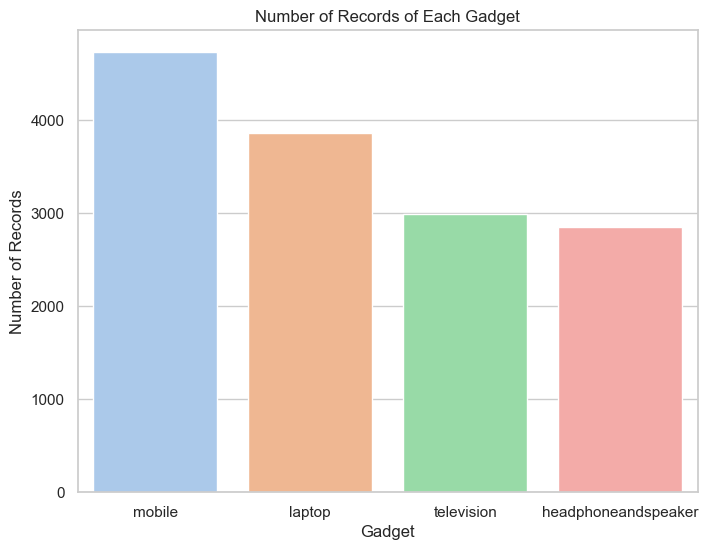

In [108]:
gadget_counts = df['Gadget'].value_counts()

# Style of the plot
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Plotting the gadget counts using Seaborn library
plt.figure(figsize=(8, 6))
sns.barplot(x=gadget_counts.index, y=gadget_counts.values)

# Adding labels and title to the plot
plt.xlabel('Gadget')
plt.ylabel('Number of Records')
plt.title('Number of Records of Each Gadget')

plt.xticks()
plt.show()


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14434 entries, 0 to 14433
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand name           14434 non-null  object 
 1   Model number         14434 non-null  object 
 2   picture url          14434 non-null  object 
 3   Price                14434 non-null  float64
 4   RAM                  14434 non-null  object 
 5   SSD                  14434 non-null  object 
 6   colour               14434 non-null  object 
 7   Operating system     14434 non-null  object 
 8   Hard disk            14434 non-null  object 
 9   Processor            14434 non-null  object 
 10  Graphics Processor   14434 non-null  object 
 11  Touch Screen         14434 non-null  object 
 12  Battery Life         14434 non-null  object 
 13  Gadget               14434 non-null  object 
 14  Rear camera          14434 non-null  object 
 15  Front camera         14434 non-null 

## Converting Price from Indian Rupee to Canadian Dollar

In [110]:
# Defining the exchange rate
exchange_rate = 0.016

df['Price'] =(df['Price'] * exchange_rate).astype(int)

## Shuffling the records to avoid the biasness in the Data 

In [111]:
df = df.sample(frac=1, random_state=78).reset_index(drop=True)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14434 entries, 0 to 14433
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Brand name           14434 non-null  object
 1   Model number         14434 non-null  object
 2   picture url          14434 non-null  object
 3   Price                14434 non-null  int32 
 4   RAM                  14434 non-null  object
 5   SSD                  14434 non-null  object
 6   colour               14434 non-null  object
 7   Operating system     14434 non-null  object
 8   Hard disk            14434 non-null  object
 9   Processor            14434 non-null  object
 10  Graphics Processor   14434 non-null  object
 11  Touch Screen         14434 non-null  object
 12  Battery Life         14434 non-null  object
 13  Gadget               14434 non-null  object
 14  Rear camera          14434 non-null  object
 15  Front camera         14434 non-null  object
 16  Inte

## Creating tags for unique identification and applying Count Vectorization on it.

In [113]:
df['Tags'] = (
    df['Gadget'].astype(str) + ' ' + df['Brand name'].astype(str) + ' ' +
    df['Price'].astype(str) + ' ' + df['colour'].astype(str) + ' ' +
    df['RAM'].astype(str) + ' ' + df['Touch Screen'].astype(str) + ' ' +
    df['Battery Life'].astype(str) + ' ' + df['SSD'].astype(str) + ' ' +
    df['Operating system'].astype(str) + ' ' + df['Hard disk'].astype(str) + ' ' +
    df['Processor'].astype(str) + ' ' + df['Graphics Processor'].astype(str) + ' ' +
    df['Rear camera'].astype(str) + ' ' + df['Front camera'].astype(str) + ' ' +
    df['Internal storage'].astype(str) + ' ' + df['Display Size'].astype(str) + ' ' +
    df['Screen Type'].astype(str) + ' ' + df['Resolution Standard'].astype(str) + ' ' +
    df['Smart TV'].astype(str) + ' ' + df['Resolution (pixels)'].astype(str) + ' ' +
    df['Type'].astype(str) + ' ' + df['Wired/Wireless'].astype(str) + ' ' +
    df['Compatible Devices'].astype(str)
)


In [114]:
df['Tags'][5]

'laptop Asus 783 Silver 8GB No 4.0 No DOS 1TB Intel Core i5 7th Gen 7200U Nvidia GeForce 920M Not Required Not Required Not Required Not Required Not Required Not Required Not Required Not Required Not Required Not Required Not Required'

### Now we have to clean these Tags before Converting it into the vectors

## Function to apply Stemming 

In [115]:
ps = PorterStemmer()
def stem(text):
    y=[]
    for i in text.split():
        y.append(ps.stem(i))
 
    return " ".join(y)


## Tokenizing the words and then Function to remove 'not' and 'required' from the Tags token that was added for the missing values and also remove the space and comma ',' from the Tags text 

In [116]:
def tokenize_words(string):
    tokenized_word = word_tokenize(string)
    return tokenized_word

In [117]:
def clean_tags(tags):
    cleaned_tags = [tag for tag in tags if tag.lower() not in ['not', 'required', ','] and tag.strip() != '']
    return ' '.join(cleaned_tags)

In [118]:
# With this the function will come to its root word and also lower case
df['Tags'].apply(stem)

0        laptop hp 1123 silver 16gb no 23.0 512gb windo...
1        mobil asu 76 white, purpl 4gb ye 3000.0 not re...
2        headphoneandspeak sennheis 1078 black not requ...
3        laptop asu 1566 black 8gb no 8.0 no windows10 ...
4        laptop dell 512 black 4gb no 8.0 no windows8.1...
                               ...                        
14429    mobil lava 139 white, black 2gb ye 4000.0 not ...
14430    mobil samsung 479 burgundi red, coral blue, li...
14431    mobil intex 35 black, white 512mb ye 2900.0 no...
14432    laptop acer 623 black 4gb no 8.0 no windows10 ...
14433    mobil blackberri 134 black, white 512mb ye 145...
Name: Tags, Length: 14434, dtype: object

In [119]:
## converting to Lower Case
df['Tags']=df['Tags'].apply(lambda x:x.lower())

In [120]:
df['Tags'][1]

'mobile asus 76 white, purple 4gb yes 3000.0 not required not required not required not required not required 13 5 64gb not required not required not required not required not required not required not required not required'

In [121]:
df['Tags']=df['Tags'].apply(tokenize_words)    

In [122]:
df['Tags'][2]

['headphoneandspeaker',
 'sennheiser',
 '1078',
 'black',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'not',
 'required',
 'headphones',
 'wireless',
 'mobile',
 ',',
 'computer',
 ',',
 'tablet']

In [123]:
# Removing "not" "required"
df['Tags'] = df['Tags'].apply(clean_tags)

In [124]:
# Here are the final tags 
df['Tags'][2]

'headphoneandspeaker sennheiser 1078 black headphones wireless mobile computer tablet'

## Removing Duplicates from the Dataframe

In [125]:
df.duplicated().sum()

143

In [126]:
df.drop_duplicates(inplace=True)

In [127]:
df.duplicated().sum()

0

## Duplicates removed!!!

In [128]:
df.reset_index(drop=True, inplace=True)
df.shape

(14291, 26)

In [129]:
#Creating item tag 
item_tags=df['Tags']

In [130]:
#Creating a copy of the tahs column for the Visualization purpose
df['Tags_copy']=df['Tags'].copy()

In [131]:
df['Tags_copy']=df['Tags_copy'].apply(tokenize_words)

## Visualizing the length of the words present in the Tags Column

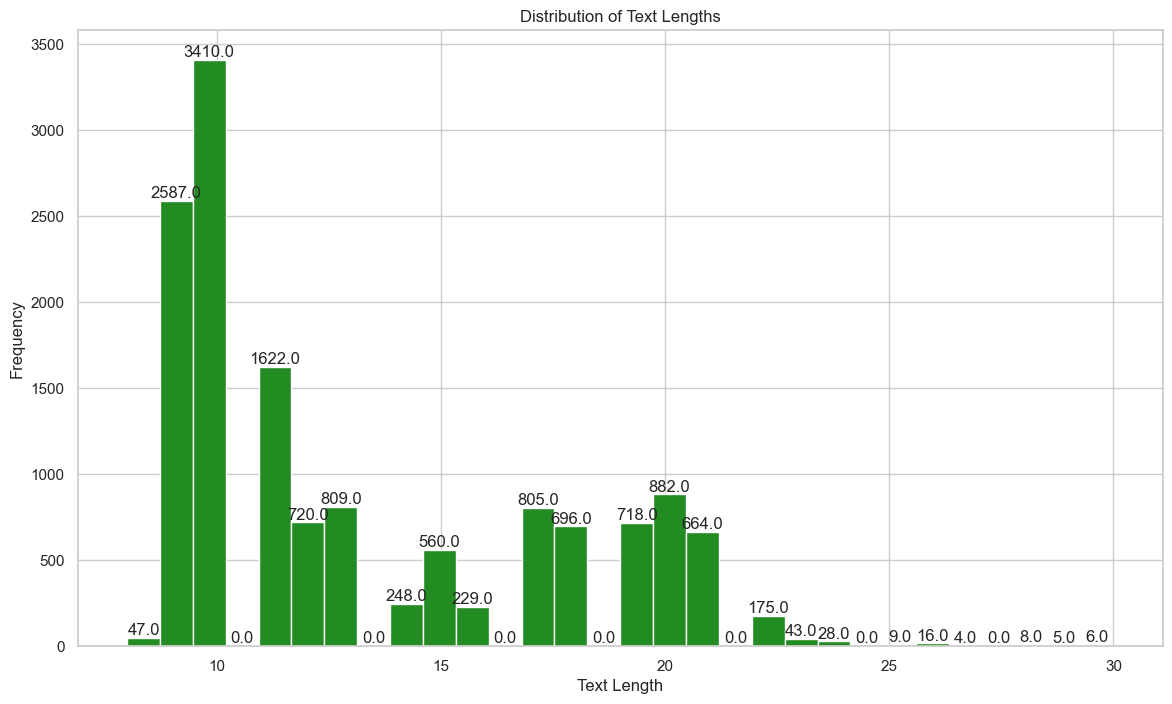

In [132]:
lengths_of_tags = df['Tags_copy'].apply(len)


# Plotting the histogram
plt.figure(figsize=(14, 8))
counts, bins, patches = plt.hist(lengths_of_tags, bins=30, color='forestgreen')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')

# Adding count labels to the bars
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, count,
             ha='center', va='bottom')

plt.show()

## Function for creating the a seperate table for the Top 30 words and the Count of it Based upon the Gadget

In [133]:
# Here we are creating a new data frame gadget_type so that we can get the records related to one gadget from the 
# Tags column, then again creating a new data Frame top_words so that we can get the top words with their count
def get_top_words_by_gadget(df, gadget, top_n=30):
    gadget_type = df[df['Gadget'] == gadget]
    words = [item for sublist in gadget_type['Tags_copy'] for item in sublist]
    word_counts = Counter(words)
    top_words = pd.DataFrame(word_counts.most_common(top_n), columns=['Top Words', 'Count'])
    return top_words

## Function for creating the bar plot for the Top Words and Count based upon the gadget

In [134]:
# After receiving the top words and count plotting a bar chart based upon the gadget 
def plot_top_words(top_words, gadget):
    plt.figure(figsize=(25, 8))
    plt.bar(top_words['Top Words'], top_words['Count'], color='blue',width=0.8)
    plt.xlabel('Top Words')
    plt.ylabel('Count')
    plt.title(f'Top Words in {gadget}')
    plt.xticks(rotation=90,fontsize=22)
    plt.show()

## Function for Creating the word cloud of the  different categories with its top words 

In [135]:
# Using the above top words and gadget to the word cloud 
def generate_word_cloud(top_words, gadget):
    # Create a dictionary of word-frequency pairs
    word_freq = dict(zip(top_words['Top Words'], top_words['Count']))

    # Generate the word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {gadget}')
    plt.show()

## Laptop

,Top Words,Count
0,no,7580
1,intel,6237
2,laptop,3863
3,core,3837
4,graphics,2715
5,8.0,2628
6,windows10,2627
7,hd,2461
8,integrated,2292
9,gen,2059


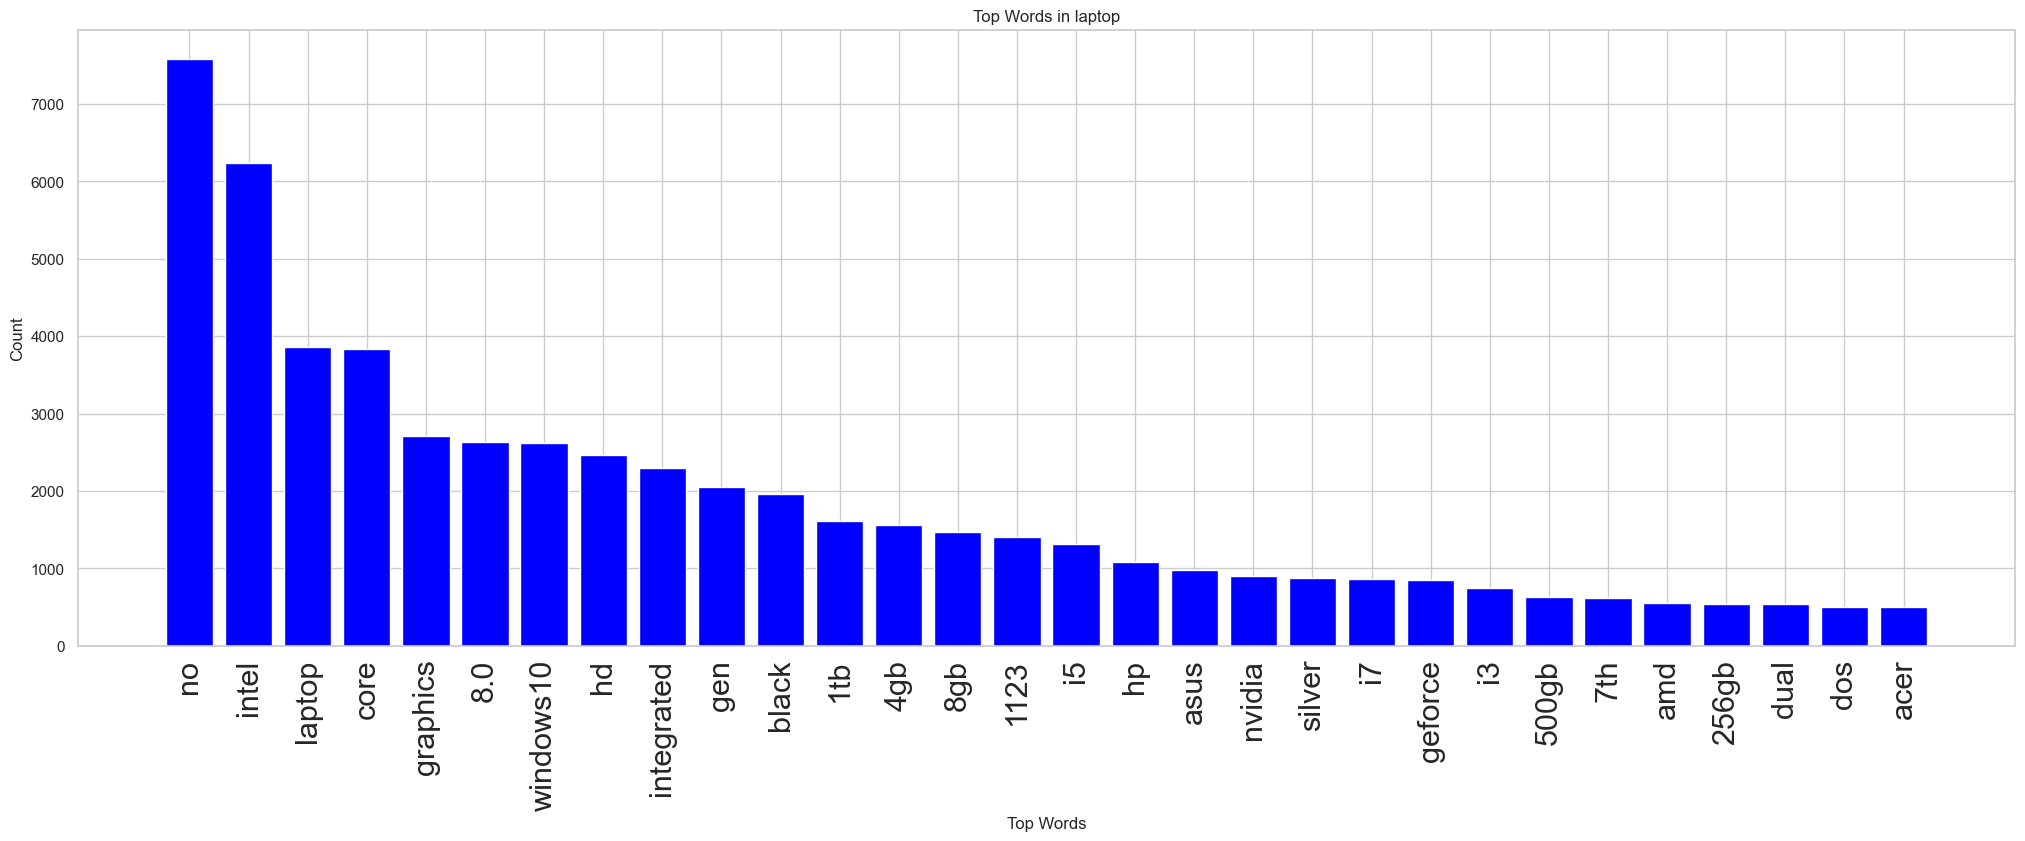

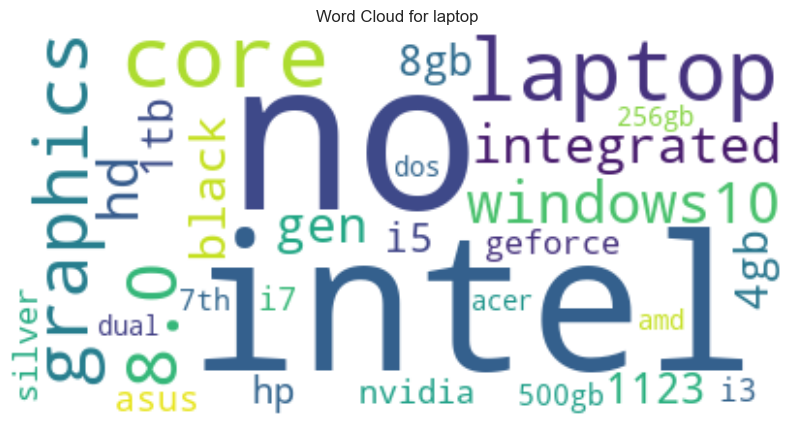

In [136]:
gadget = 'laptop'
top_laptop = get_top_words_by_gadget(df, gadget, top_n=30)
display(top_laptop.style.background_gradient(cmap='Blues'))
plot_top_words(top_laptop, gadget)
generate_word_cloud(top_laptop, gadget)

## Mobile

,Top Words,Count
0,mobile,4645
1,yes,4595
2,black,3411
3,5,2281
4,white,2214
5,8,1752
6,gold,1651
7,13,1545
8,blue,1493
9,16gb,1195


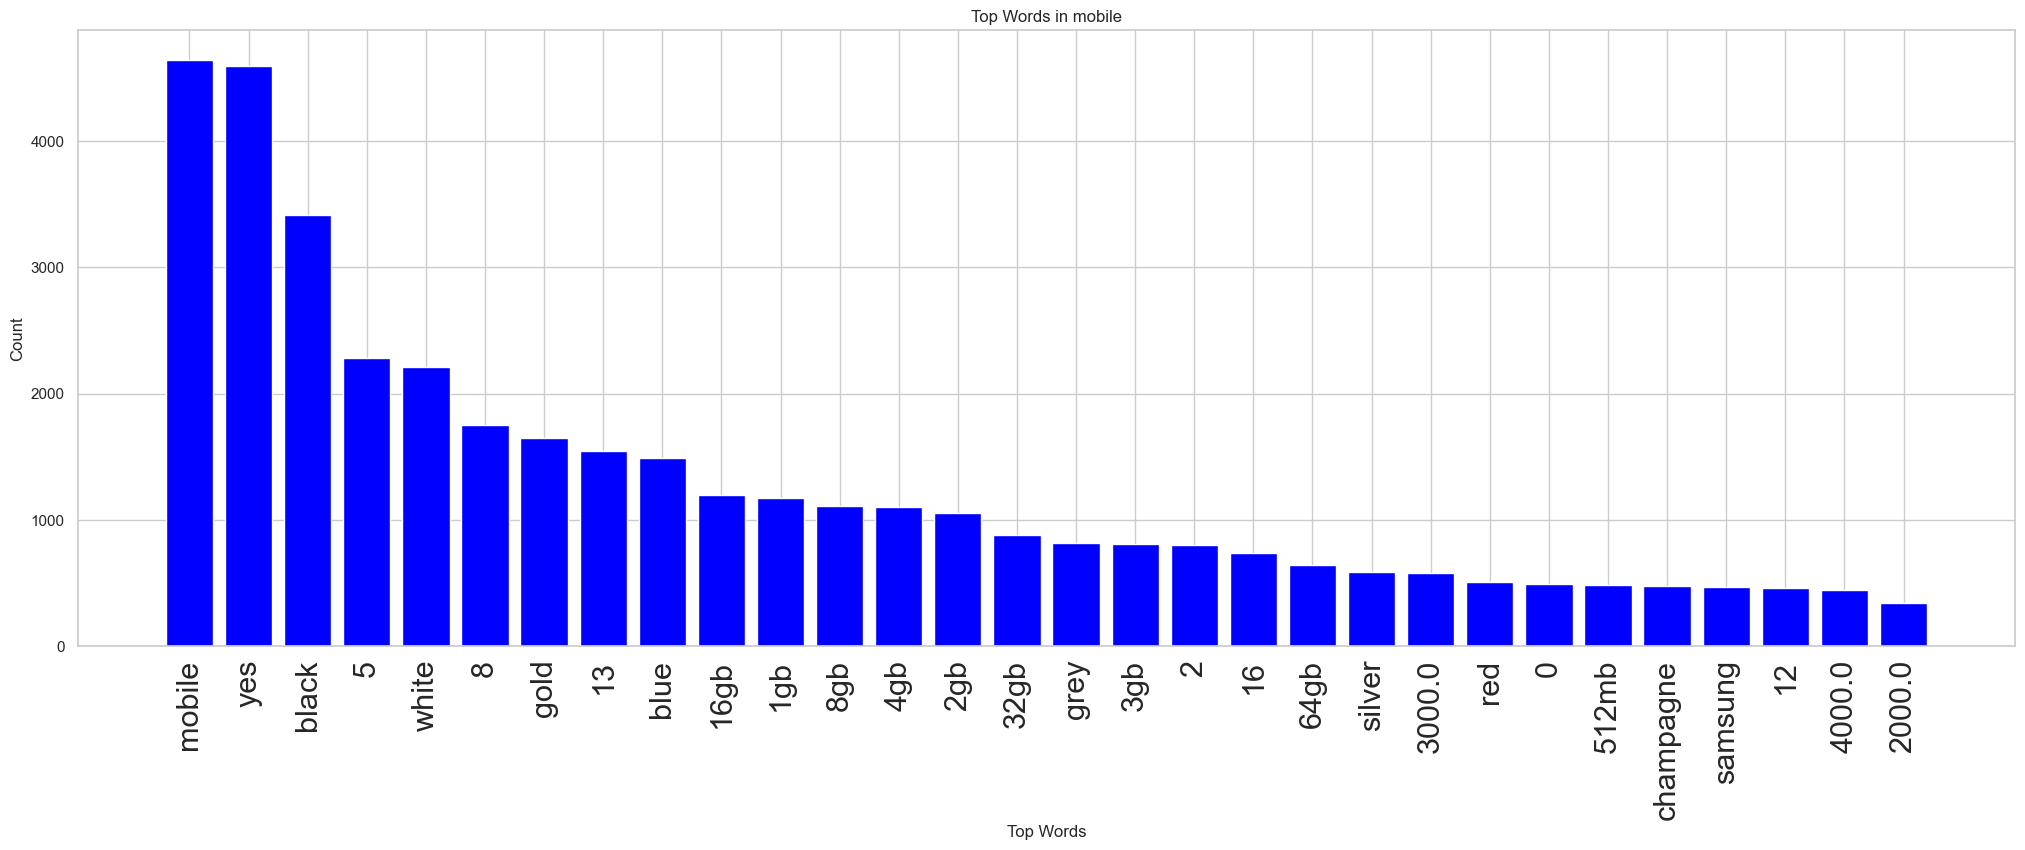

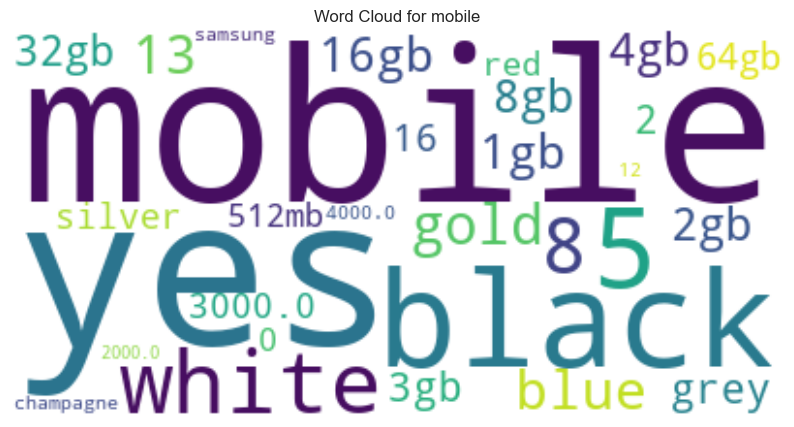

In [137]:
gadget = 'mobile'
top_mobile = get_top_words_by_gadget(df, gadget, top_n=30)
display(top_mobile.style.background_gradient(cmap='Blues'))
plot_top_words(top_mobile, gadget)
generate_word_cloud(top_mobile, gadget)

## Television

,Top Words,Count
0,television,2992
1,inch,2992
2,led,2833
3,black,2749
4,1920x1080,1821
5,no,1794
6,1124,1469
7,full-hd,1341
8,yes,1198
9,hd-ready,906


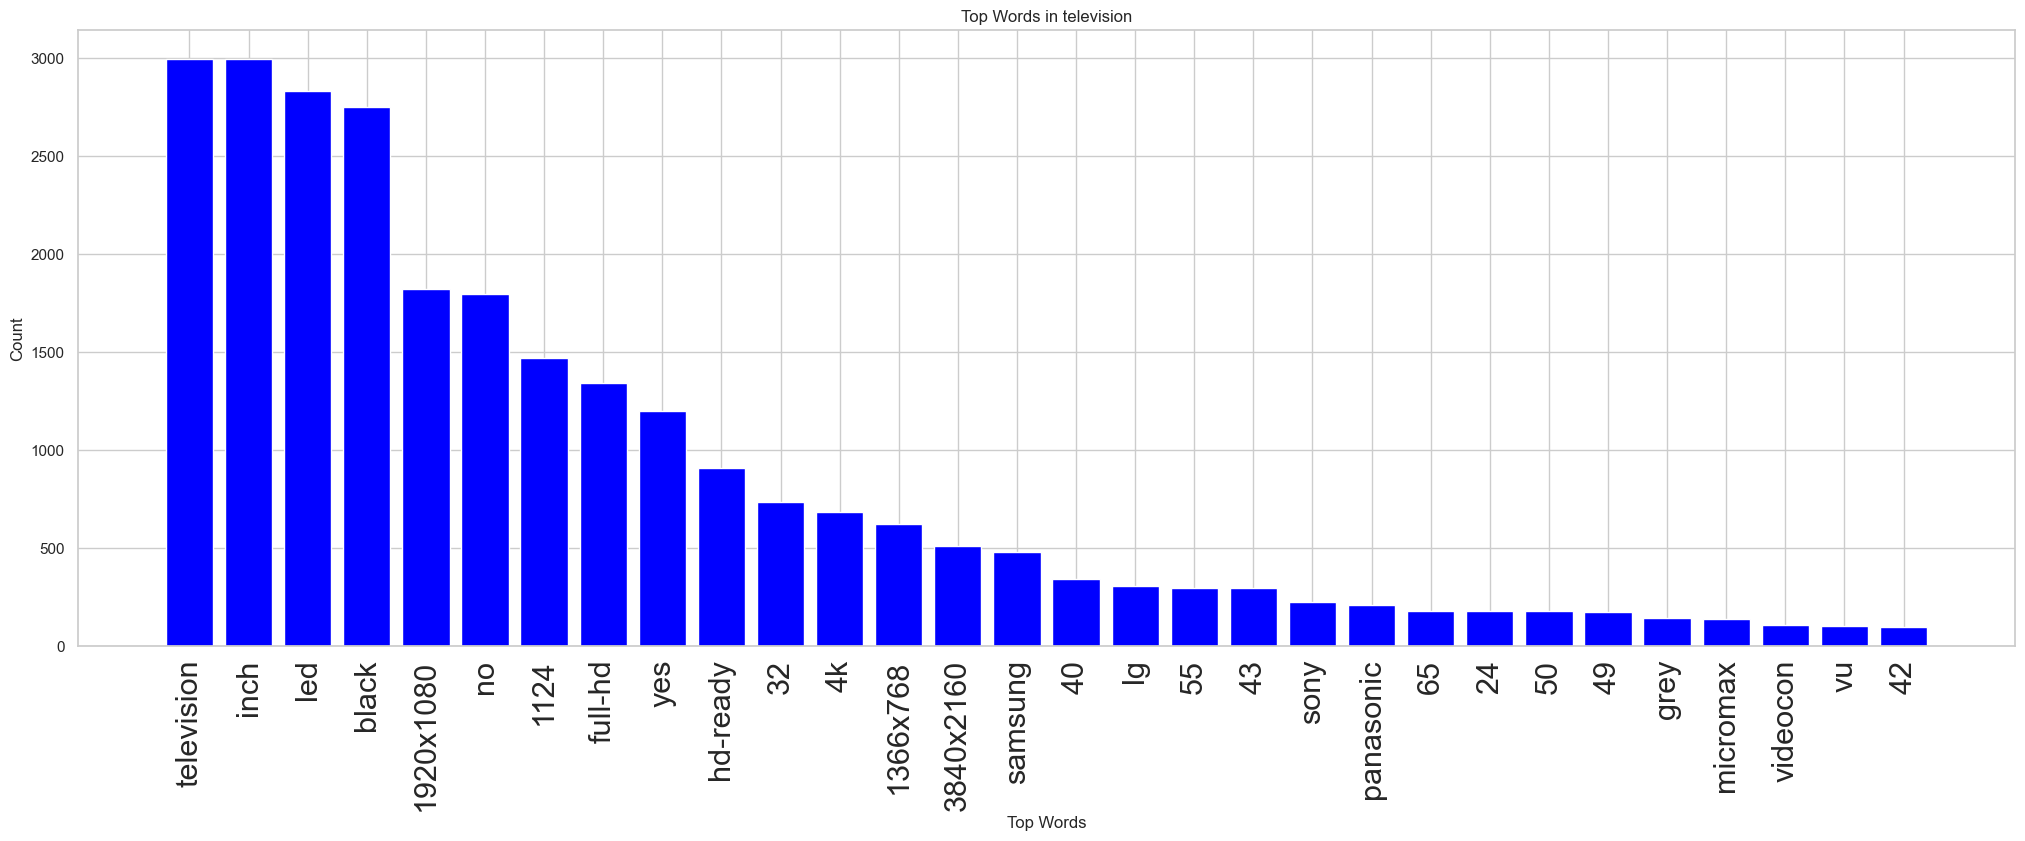

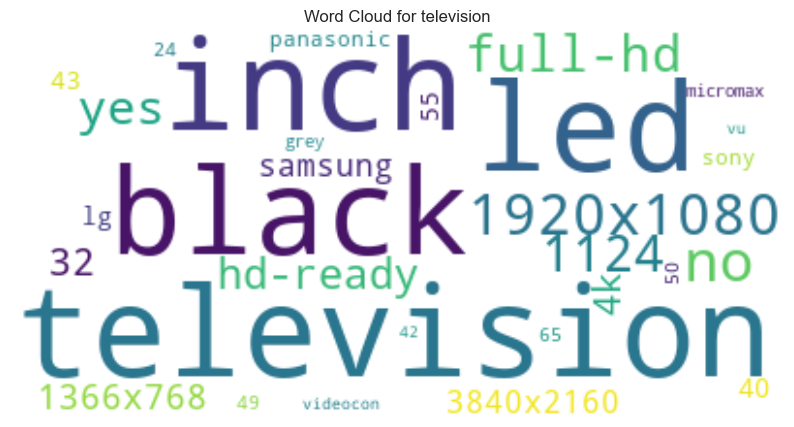

In [138]:
gadget = 'television'
top_television = get_top_words_by_gadget(df, gadget, top_n=30)
display(top_television.style.background_gradient(cmap='Blues'))
plot_top_words(top_television, gadget)
generate_word_cloud(top_television, gadget)

## Headphoneandspeaker

,Top Words,Count
0,headphoneandspeaker,2800
1,computer,2799
2,mobile,2753
3,tablet,2708
4,black,1726
5,wired,1587
6,wireless,1213
7,earphones,915
8,headphones,890
9,speaker,756


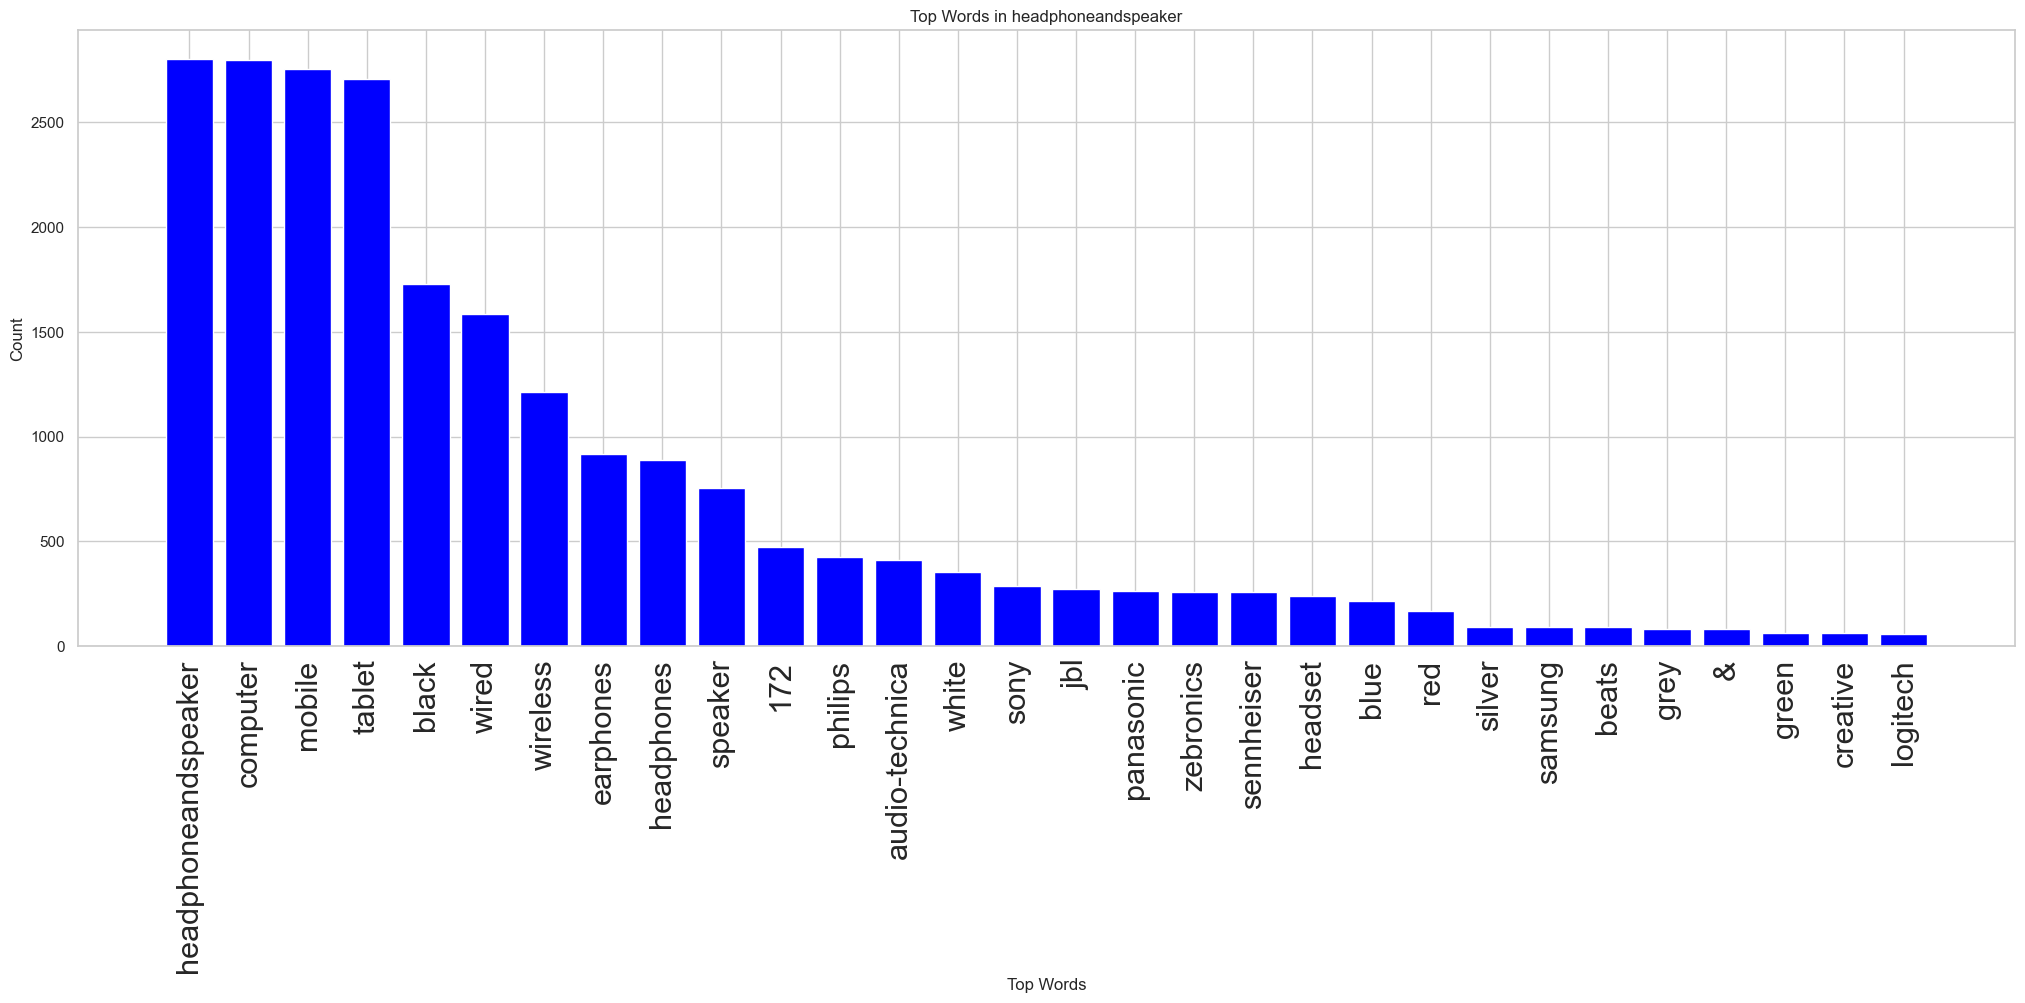

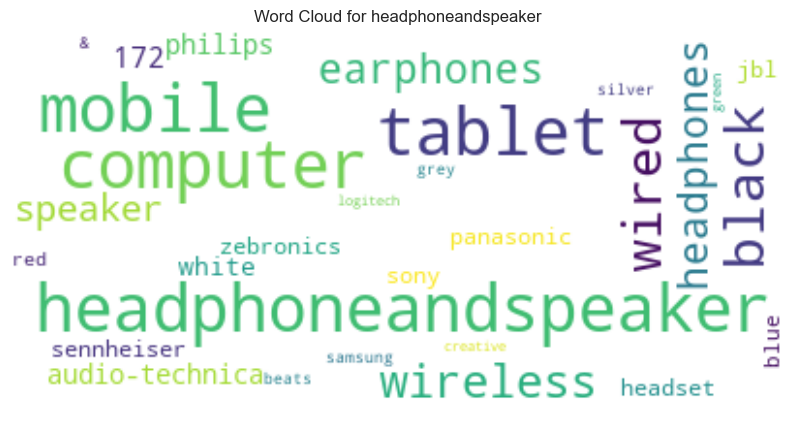

In [139]:
gadget = 'headphoneandspeaker'
top_headphoneandspeaker = get_top_words_by_gadget(df, gadget, top_n=30)
display(top_headphoneandspeaker.style.background_gradient(cmap='Blues'))
plot_top_words(top_headphoneandspeaker, gadget)
generate_word_cloud(top_headphoneandspeaker, gadget)

## Now Creating the user Tags for Dynamically for the Each Gadget

In [140]:
def generate_user_tags(input_features):
    tags = []
    gadget_name = input_features['Gadget']
    
    if gadget_name == 'laptop':
        tags.append(str(input_features['Gadget']))
        tags.append(str(input_features['Brand name']))
        tags.append(str(input_features['Price']))
        tags.append(str(input_features['colour']))
        tags.append(str(input_features['RAM']))
        tags.append(str(input_features['Touch Screen']))
        tags.append(str(input_features['Battery Life']))
    
    elif gadget_name == 'mobile':
        tags.append(str(input_features['Gadget']))
        tags.append(str(input_features['Brand name']))
        tags.append(str(input_features['Price']))
        tags.append(str(input_features['colour']))
        tags.append(str(input_features['RAM']))
        tags.append(str(input_features['Touch Screen']))
        tags.append(str(input_features['Battery Life']))
        tags.append(str(input_features['Rear camera']))
        tags.append(str(input_features['Front camera']))
        tags.append(str(input_features['Internal storage']))
    
    elif gadget_name == 'television':
        tags.append(str(input_features['Gadget']))
        tags.append(str(input_features['Brand name']))
        tags.append(str(input_features['Price']))
        tags.append(str(input_features['colour']))
        tags.append(str(input_features['Display Size']))
        tags.append(str(input_features['Screen Type']))
        tags.append(str(input_features['Resolution Standard']))
        tags.append(str(input_features['Smart TV']))
        tags.append(str(input_features['Resolution (pixels)']))
    
    elif gadget_name == 'headphoneandspeaker':
        tags.append(str(input_features['Gadget']))
        tags.append(str(input_features['Brand name']))
        tags.append(str(input_features['Price']))
        tags.append(str(input_features['colour']))
        tags.append(str(input_features['Type']))
        tags.append(str(input_features['Wired/Wireless']))
        tags.append(str(input_features['Compatible Devices']))
    
    return ' '.join(tags)


## Getting the input from the User about the Type and Features of the Gadget

In [141]:
# Get user input for product name, price, and features
input_gadget = input("Enter the gadget: ")
input_brand_name = input("Enter the brand: ")
input_price = str(input("Enter the price: "))
input_colour = input("Enter the colour: ")

input_features = {
    'Gadget': input_gadget,
    'Brand name': input_brand_name,
    'Price': input_price,
    'colour': input_colour,
}

if input_gadget == 'laptop':
    input_ram = input("Enter the RAM: ")
    input_ssd = input("Enter the SSD: ")
    input_os = input("Enter the operating system: ")
    input_hard_disk = input("Enter the hard disk: ")
    input_processor = input("Enter the processor: ")
    input_graphics_processor = input("Enter the graphics processor: ")
    input_touch_screen = input("Enter Yes or No for touch screen: ")
    input_battery_life = input("Enter the battery life: ")

    input_features['RAM'] = input_ram
    input_features['SSD'] = input_ssd
    input_features['Operating system'] = input_os
    input_features['Hard disk'] = input_hard_disk
    input_features['Processor'] = input_processor
    input_features['Graphics Processor'] = input_graphics_processor
    input_features['Touch Screen'] = input_touch_screen
    input_features['Battery Life'] = input_battery_life
    
elif input_gadget == 'mobile':
    input_ram = input("Enter the RAM ")
    input_touch_screen = input("Enter Yes or No for Touch Screen: ")
    input_battery_life = input("Enter the Battery Capacity: ")
    input_rear_camera = input("Enter Rear camera: ")
    input_front_camera = input("Enter Front Camera: ")
    input_internal_storage = input("Enter Internal Storage: ")

    input_features['RAM'] = input_ram
    input_features['Touch Screen'] = input_touch_screen
    input_features['Battery Life'] = input_battery_life
    input_features['Rear camera'] = input_rear_camera
    input_features['Front camera'] = input_front_camera
    input_features['Internal storage'] = input_internal_storage

elif input_gadget == 'television':
    input_display_size = input("Enter the display size: ")
    input_screen_type = input("Enter the screen type: ")
    input_resolution_standard = input("Enter the resolution standard: ")
    input_smart_tv = input("Enter Yes or No for smart TV: ")
    input_resolution = input("Enter the resolution (pixels): ")

    input_features['Display Size'] = input_display_size
    input_features['Screen Type'] = input_screen_type
    input_features['Resolution Standard'] = input_resolution_standard
    input_features['Smart TV'] = input_smart_tv
    input_features['Resolution (pixels)'] = input_resolution

elif input_gadget == 'headphoneandspeaker':
    input_type = input("Enter the type: ")
    input_wired_wireless = input("Enter Wired or Wireless: ")
    input_compatible_devices = input("Enter the compatible devices: ")

    input_features['Type'] = input_type
    input_features['Wired/Wireless'] = input_wired_wireless
    input_features['Compatible Devices'] = input_compatible_devices
#headphoneandspeaker sennheiser 1078 black headphones wireless mobile computer tablet

KeyboardInterrupt: Interrupted by user

## Calling the User Tags Function

In [ ]:
user_tags=generate_user_tags(input_features)

## Applying the Stemming on the User Tags|

In [ ]:
user_tags=stem(user_tags)

## Applying Count Vectorization to the tags to convert it to Vectors

Earlier i  tried finding out the similatriltites by combining the user and item tag into one, I achived pretty good output but  there were some errors due to the data 
so i needed more accuracy and uniqueness between the user and Item tags so i thought of creating a seperate column for the gadget and brand_name so that the user should get only the recommnedations related to the Gadget and Brand name Specified by the him

To achive this i have created two seperate vectors
  * one for the tag_vectors and another for the gadget_brand_vectors present in the Data frame 
  * Similarlty for the user tags and (gadget and brand name specifed by the user)
  
  
Then i find out the cosine similarities between the user_tag and item_tag 
 and similaritites between the gadget_brand_vectors and user_gadget_brand_vector

Now we will have two similairites with respect to the input given by the user, then we will do two things here:
  * Apply weightage to both the similairites in a way that similarities_gadget_brand should have more weightage
  * combine those into one similarities and get the two n similar items

In [ ]:
## Create a CountVectorizer
cv = CountVectorizer()

## Combine the gadget and Brand name columns into a new column
df['Gadget_Brand'] = df['Gadget'] + ' ' + df['Brand name']

## Fit and transform the item Tags and Gadget_Brand Column
tag_vectors = cv.fit_transform(df['Tags'])
gadget_brand_vectors = cv.transform(df['Gadget_Brand'])

## Transform the user tags and Gadget_Brand into vectors which are sopecified by the user
user_tag_vector = cv.transform([user_tags])
user_gadget_brand_vector = cv.transform([input_gadget + ' ' + input_brand_name]) 

## Calculate the cosine similarity between user tags and Item_tags
similarities_tag = cosine_similarity(user_tag_vector, tag_vectors)

## Calculate the cosine similarity between user gadget_model and item gadget_model
similarities_gadget_brand = cosine_similarity(user_gadget_brand_vector, gadget_brand_vectors)

## Increase weightage for gadget and brand similairity
similarities_tag *= 0.5 
similarities_gadget_brand *= 1.5

## Combine the similarities
similarities_combined = similarities_tag + similarities_gadget_brand

## Get the indices of top n similar items
top_indices = similarities_combined.argsort()[0][::-1][:6]

## Print the details of top similar items
for index in top_indices:
    print(df.iloc[index]['Brand name'])
    print(df.iloc[index]['Model number'])
    print(df.iloc[index]['Price'])
    print(df.iloc[index]['Tags'])
    print()
